# 1. Data set

Do przechowywania danych użyto SQLite, ze względu na jego komaptybilność z Rsutem i Reactem( w których projekt zostało napisany), prostą implementację, a szczególnie na szybki i nisko-kosztowny dostęp do danych. Jeśli miałby to być serwer z większą ilością zapytań to wybrałbym Mongo, ale tutaj dla offline, prostej i nie obsługującej dużej liczby zapytań jest baza SQL.


Dane pobrano ze strony: https://dumps.wikimedia.org/enwiki/latest/ 


Posłużono się wersją Simple Wiki [Eng]

Dane z pliku xml przeparsowano na pliki txt wikiextracotrem(https://github.com/attardi/wikiextractor) w lekko zmodyfikowanej wersji dla tego zadania


Oddzielnie wprowadzono dane z plików txt do bazy sqlite 

In [ ]:
import sqlite3
import re
import glob

def parse_file(file_path):
    docs = []
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        pattern = r'<doc id="(\d+)" url="(https?://[^"]+)" title="([^"]+)">([^<]+)<\/doc>'
        matches = re.findall(pattern, content)
        for match in matches:
            doc_id = match[0]
            url = match[1]
            title = match[2]
            text = match[3]
            docs.append((doc_id, title, url, text))
    return docs

def create_db_and_insert_data(docs):
    conn = sqlite3.connect('articles.db')
    cursor = conn.cursor()

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS articles (
            id INTEGER PRIMARY KEY,
            title TEXT,
            url TEXT,
            text TEXT
        )
    ''')

    cursor.executemany('''
        INSERT INTO articles (id, title, url, text)
        VALUES (?, ?, ?, ?)
    ''', docs)

    conn.commit()
    conn.close()

def main():
    folders = ['AA/*', 'AC/*', 'AB/*']
    for file in folders:
        file_paths = glob.glob(f)
        all_docs = []
        for file_path in file_paths:
            print(f'Przetwarzam plik: {file_path}')
            docs = parse_file(file_path)
            all_docs.extend(docs)

        if all_docs:
            create_db_and_insert_data(all_docs)
            print("Dane zostały zapisane w bazie danych.")
        else:
            print("Brak danych do zapisania.")

Alternatywna wersja rozwiazania( uzywanie api wikipedii i sciagnie losowych artykulow )

In [ ]:
import sqlite3
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from tqdm import tqdm
# implementacja wspomagana przez AI
DATABASE_NAME = "wikipedia_fast.db"
WIKIPEDIA_API_URL = "https://en.wikipedia.org/w/api.php"
TARGET_ARTICLE_COUNT = 300000
THREADS = 50  
BATCH_SIZE = 500 

def init_db():
    conn = sqlite3.connect(DATABASE_NAME)
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS articles (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        title TEXT UNIQUE,
        content TEXT
    )
    """)
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_title ON articles(title)")
    conn.commit()
    conn.close()

def get_article_list(limit):
    params = {
        "action": "query",
        "format": "json",
        "list": "allpages",
        "aplimit": limit,
        "apfilterredir": "nonredirects"
    }
    response = requests.get(WIKIPEDIA_API_URL, params=params)
    data = response.json()
    return [page["title"] for page in data["query"]["allpages"]]

def fetch_article(title):
    try:
        params = {
            "action": "query",
            "format": "json",
            "prop": "extracts",
            "titles": title,
            "explaintext": True,
            "exsectionformat": "plain"
        }
        response = requests.get(WIKIPEDIA_API_URL, params=params, timeout=10)
        data = response.json()
        page = next(iter(data["query"]["pages"].values()))
        return (title, page.get("extract", ""))
    except:
        return None

def save_batch(batch):
    conn = sqlite3.connect(DATABASE_NAME)
    cursor = conn.cursor()
    cursor.executemany(
        "INSERT OR IGNORE INTO articles (title, content) VALUES (?, ?)",
        [(title, content) for title, content in batch if content]
    )
    conn.commit()
    conn.close()

def main():
    init_db()
    
    conn = sqlite3.connect(DATABASE_NAME)
    cursor = conn.cursor()
    cursor.execute("SELECT COUNT(*) FROM articles")
    existing = cursor.fetchone()[0]
    conn.close()
    
    if existing >= TARGET_ARTICLE_COUNT: return
    
    needed = TARGET_ARTICLE_COUNT - existing
    
    print("Pobieranie...")
    articles = get_article_list(needed * 2)
    articles = articles[:needed + 10000] 
    
    batch = []
    start_time = time.time()
    
    with ThreadPoolExecutor(max_workers=THREADS) as executor:
        futures = {executor.submit(fetch_article, title): title for title in articles}
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Pob"):
            result = future.result()
            if result:
                batch.append(result)
                
                if len(batch) >= BATCH_SIZE:
                    save_batch(batch)
                    batch = []
    
    if batch:
        save_batch(batch)
    
    elapsed = time.time() - start_time
    print(f"Zakonczono w {elapsed:.2f} seknd")

Prosty Web scraper( nie uzyty, bo dziala za wolno)

In [ ]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time

NUM_ARTICLES = 300000

conn = sqlite3.connect('articles.db')
cursor = conn.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS articles (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        url TEXT UNIQUE,
        title TEXT,
        text TEXT
    )
''')

def scrape_random_article():
    try:
        response = requests.get('https://pl.wikipedia.org/wiki/Special:Random', allow_redirects=True)
        final_url = response.url 
        soup = BeautifulSoup(response.text, 'html.parser')
        title = soup.find('h1').get_text()
        paragraphs = soup.select('div.mw-parser-output > p')
        text = '\n'.join(p.get_text() for p in paragraphs if p.get_text(strip=True))
        return final_url, title, text
    except Exception as e:
        print(f"Error: {e}")
        return None, None, None

for _ in range(NUM_ARTICLES):
    url, title, text = scrape_random_article()
    if title and text:
        try:
            cursor.execute(
                'INSERT INTO articles (url, title, text) VALUES (?, ?, ?)',
                (url, title, text)
            )
            conn.commit()
        except sqlite3.IntegrityError:
    time.sleep(1)  # zeby nie zablokowac serwera

conn.close()

Początkowo łącznie użyto ~350k dokumentów ( 370847), a słownik zawierał ~500k słów (494618). Jednak po impelmentacji pełnego algorytmu zauważono nieprawidłowości działania SVD i klasyfikacji wartości score ze względu na krótkość opisów artykułów( prawdopodbnie spowodowane wadliwym działaniem extractora), edytowano dane i ponownie obliczono zawartość słownika i liczbę dokumentów.

Po tej operacji, nowa wersja dokumentów wyniosła: 223412.

# 2. - 7. Bazowa implementacja


Do implementacji zadania posłużono się językiem Rust ze względu na jego szybkość, wydajność i wbudowaną obsługę zarządzania pamięcią.

Jeszcze przed rozpoczęciem obliczeń stowrzono plik stop_words, który wyelimunej nam nieużyteczne słowa.

Dodatkowo zaimplementowano Porter Stemming Algorithm do przekształcenia wspólnych końcówek morfologicznych i fleksyjnych

In [ ]:
fn is_vowel(word: &[char], i: usize) -> bool {
    let c = word[i];
    match c {
        'a' | 'e' | 'i' | 'o' | 'u' => true,
        'y' => i > 0 && !is_vowel(word, i - 1),
        _ => false,
    }
}

fn measure(word: &[char]) -> usize {
    let mut m = 0;
    let mut prev_vowel = false;

    for i in 0..word.len() {
        let current_vowel = is_vowel(word, i);
        if prev_vowel && !current_vowel {
            m += 1;
        }
        prev_vowel = current_vowel;
    }

    m
}

fn has_vowel(word: &[char]) -> bool {
    word.iter().enumerate().any(|(i, _)| is_vowel(word, i))
}

fn ends_with_cvc(word: &[char]) -> bool {
    if word.len() < 3 {
        return false;
    }

    let i = word.len() - 3;
    let last_c = word[i + 2];
    !is_vowel(word, i) && is_vowel(word, i + 1) && !is_vowel(word, i + 2) &&
        !['w', 'x', 'y'].contains(&last_c)
}

fn replace_suffix(word: &mut Vec<char>, suffix: &str, replacement: &str) -> bool {
    let suffix_chars: Vec<char> = suffix.chars().collect();
    let replacement_chars: Vec<char> = replacement.chars().collect();

    if word.ends_with(&suffix_chars) {
        let new_len = word.len() - suffix_chars.len();
        word.truncate(new_len);
        word.extend(replacement_chars);
        true
    } else {
        false
    }
}

fn replace_suffix_condition<F>(word: &mut Vec<char>, suffix: &str, replacement: &str, condition: F) -> bool
where
    F: Fn(&[char]) -> bool,
{
    let suffix_chars: Vec<char> = suffix.chars().collect();
    if word.ends_with(&suffix_chars) {
        let stem = &word[..word.len() - suffix_chars.len()];
        if condition(stem) {
            replace_suffix(word, suffix, replacement);
            true
        } else {
            false
        }
    } else {
        false
    }
}

fn step_1a(word: &mut Vec<char>) {
    if replace_suffix(word, "sses", "ss") { return }
    if replace_suffix(word, "ies", "i") { return }
    if replace_suffix(word, "ss", "ss") { return }

    if word.ends_with(&['s']) {
        let stem = &word[..word.len() - 1];
        if has_vowel(stem) {
            word.pop();
        }
    }
}

fn step_1b(word: &mut Vec<char>) {
    if replace_suffix_condition(word, "eed", "ee", |stem| measure(stem) > 0) {
        return;
    }

    let mut modified = false;
    let original = word.clone();

    if replace_suffix(word, "ed", "") && has_vowel(word) {
        modified = true;
    } else {
        *word = original.clone();
    }

    if !modified && replace_suffix(word, "ing", "") && has_vowel(word) {
        modified = true;
    } else if !modified {
        *word = original;
    }

    if modified {
        if replace_suffix(word, "at", "ate") ||
            replace_suffix(word, "bl", "ble") ||
            replace_suffix(word, "iz", "ize") {
            return;
        }

        if word.len() >= 2 {
            let last = word[word.len() - 1];
            let prev = word[word.len() - 2];
            if last == prev && !is_vowel(word, word.len() - 1) && !['l', 's', 'z'].contains(&last) {
                word.pop();
                return;
            }
        }

        if measure(word) == 1 && ends_with_cvc(word) {
            word.push('e');
        }
    }
}

fn step_1c(word: &mut Vec<char>) {
    if word.ends_with(&['y']) && has_vowel(&word[..word.len() - 1]) {
        word.pop();
        word.push('i');
    }
}

fn step_2(word: &mut Vec<char>) {
    let suffixes = [
        ("ational", "ate"), ("tional", "tion"), ("enci", "ence"),
        ("anci", "ance"), ("izer", "ize"), ("abli", "able"),
        ("alli", "al"), ("entli", "ent"), ("eli", "e"),
        ("ousli", "ous"), ("ization", "ize"), ("ation", "ate"),
        ("ator", "ate"), ("alism", "al"), ("iveness", "ive"),
        ("fulness", "ful"), ("ousness", "ous"), ("aliti", "al"),
        ("iviti", "ive"), ("biliti", "ble")
    ];

    for &(suffix, replacement) in &suffixes {
        if replace_suffix_condition(word, suffix, replacement, |stem| measure(stem) > 0) {
            return;
        }
    }
}

fn step_3(word: &mut Vec<char>) {
    let suffixes = [
        ("icate", "ic"), ("ative", ""), ("alize", "al"),
        ("iciti", "ic"), ("ical", "ic"), ("ful", ""),
        ("ness", "")
    ];

    for &(suffix, replacement) in &suffixes {
        if replace_suffix_condition(word, suffix, replacement, |stem| measure(stem) > 0) {
            return;
        }
    }
}

fn step_4(word: &mut Vec<char>) {
    let suffixes = [
        "al", "ance", "ence", "er", "ic", "able", "ible",
        "ant", "ement", "ment", "ent", "ou", "ism", "ate",
        "iti", "ous", "ive", "ize"
    ];

    for &suffix in &suffixes {
        if replace_suffix_condition(word, suffix, "", |stem| measure(stem) > 1) {
            return;
        }
    }

    if replace_suffix_condition(word, "ion", "", |stem| {
        stem.ends_with(&['s']) || stem.ends_with(&['t']) && measure(stem) > 1
    }) {}
}

fn step_5a(word: &mut Vec<char>) {
    if word.ends_with(&['e']) {
        let stem = &word[..word.len() - 1];
        let m = measure(stem);
        if m > 1 || (m == 1 && !ends_with_cvc(stem)) {
            word.pop();
        }
    }
}

fn step_5b(word: &mut Vec<char>) {
    if measure(word) > 1 && word.ends_with(&['l']) && word[word.len() - 2] == 'l' {
        word.pop();
    }
}

pub fn porter_stem(word: &str) -> String {
    let mut word = word.to_lowercase().chars().collect::<Vec<_>>();

    if word.len() <= 2 {
        return word.into_iter().collect();
    }

    step_1a(&mut word);
    step_1b(&mut word);
    step_1c(&mut word);
    step_2(&mut word);
    step_3(&mut word);
    step_4(&mut word);
    step_5a(&mut word);
    step_5b(&mut word);

    word.into_iter().collect()
}


Następnie zaimplementowany parser, który pobiera dane z bazy SQL i przerabia je na strukture Document

In [ ]:
use rusqlite::{Connection, Result};
use std::path::Path;

#[derive(Debug)]
pub struct Document {
    pub id: i64,
    pub title: String,
    pub url: String,
    pub text: String,
}

pub fn parse_sqlite_documents(db_path: &str) -> SqliteResult<Vec<Document>> {
    let conn = Connection::open(Path::new(db_path))?;

    let mut stmt = conn.prepare("SELECT id, title, url, text FROM articles")?;
    let document_iter = stmt.query_map([], |row| {
        Ok(Document {
            id: row.get(0)?,
            title: row.get(1)?,
            url: row.get(2)?,
            text: row.get(3)?,
        })
    })?;

    let mut documents = Vec::new();
    for doc in document_iter {
        documents.push(doc?);
    }

    Ok(documents)
}

Pozniej zakodowano tokenizer, ktorzy stowrzy alfabet uwzgledniajaca stop_words, a potem tworzy macierz przeszukiwania dla danych

In [ ]:
use std::collections::{HashMap, HashSet};
use std::fs::File;
use nalgebra_sparse::CooMatrix;
use regex::Regex;
use crate::{util, Document};
use std::io::{BufRead, BufReader};

pub fn build_term_document_matrix(documents: &[Document]) -> (HashMap<String, usize>, HashMap<usize, String>, CooMatrix<f64>) {
    // Load stop words (handle error appropriately for your application)
    let stop_words = load_stop_words("english.txt").unwrap_or_else(|e| {
        eprintln!("Warning: Could not load stop words file: {}. Continuing without stop words.", e);
        HashSet::new()
    });

    let mut term_dict = HashMap::new();
    let mut inverse_term_dict = HashMap::new();
    let mut term_index = 0;

    for doc in documents {
        let tokens = tokenize(&doc.text);
        for token in tokens {
            if stop_words.contains(&token.to_lowercase()) {
                continue;
            }

            // Apply Porter stemming to the token
            let stemmed_token = util::steming::porter_stem(&token);

            if !term_dict.contains_key(&stemmed_token) {
                term_dict.insert(stemmed_token.clone(), term_index);
                inverse_term_dict.insert(term_index, stemmed_token);
                term_index += 1;
            }
        }
    }

    println!("Dictionary built with {} terms (after stop words removal and stemming)", term_dict.len());

    let num_terms = term_dict.len();
    let num_docs = documents.len();

    let mut row_indices = Vec::new();
    let mut col_indices = Vec::new();
    let mut values = Vec::new();

    for (doc_idx, doc) in documents.iter().enumerate() {
        let tokens = tokenize(&doc.text);

        let mut term_counts = HashMap::new();
        for token in tokens {
            // Skip stop words
            if stop_words.contains(&token.to_lowercase()) {
                continue;
            }

            // Apply Porter stemming to the token before counting
            let stemmed_token = util::steming::porter_stem(&token);
            if let Some(&term_idx) = term_dict.get(&stemmed_token) {
                *term_counts.entry(term_idx).or_insert(0.0) += 1.0;
            }
        }

        for (term_idx, &count) in term_counts.iter() {
            row_indices.push(*term_idx);
            col_indices.push(doc_idx);
            values.push(count);
        }
    }

    let coo = CooMatrix::try_from_triplets(
        num_terms,
        num_docs,
        row_indices,
        col_indices,
        values,
    ).unwrap();

    (term_dict, inverse_term_dict, coo)
}

// Helper function to tokenize text into words
pub fn tokenize(text: &str) -> Vec<String> {
    let re = Regex::new(r"[^a-zA-Z0-9]+").unwrap();
    re.split(text)
        .filter(|s| !s.is_empty() && s.len() > 2)
        .map(|s| s.to_lowercase())
        .collect()
}
// Function to load stop words from a file
fn load_stop_words(filename: &str) -> std::io::Result<HashSet<String>> {
    let file = File::open(filename)?;
    let reader = BufReader::new(file);
    let mut stop_words = HashSet::new();

    for line in reader.lines() {
        let word = line?.trim().to_string();
        if !word.is_empty() {
            stop_words.insert(word);
        }
    }

    Ok(stop_words)
}



IDF

In [ ]:
use nalgebra_sparse::{CooMatrix, CsrMatrix};

pub fn calculate_idf(term_doc_matrix: &CsrMatrix<f64>) -> Vec<f64> {
    let num_terms = term_doc_matrix.nrows();
    let num_docs = term_doc_matrix.ncols();
    let num_docs_f64 = num_docs as f64;

    let mut idf = vec![0.0; num_terms];

    for term_idx in 0..num_terms {
        let row_start = term_doc_matrix.row_offsets()[term_idx];
        let row_end = term_doc_matrix.row_offsets()[term_idx + 1];
        let mut doc_set = std::collections::HashSet::new();
        for idx in row_start..row_end {
            doc_set.insert(term_doc_matrix.col_indices()[idx]);
        }
        let doc_count = doc_set.len() as f64;

        if doc_count > 0.0 {
            idf[term_idx] = (num_docs_f64 / doc_count).ln();
        }
    }

    idf
}

pub fn apply_idf_weighting(term_doc_matrix: &mut CsrMatrix<f64>, idf: &[f64]) {
    let mut triplets = Vec::new();

    for i in 0..term_doc_matrix.nrows() {
        let row_start = term_doc_matrix.row_offsets()[i];
        let row_end = term_doc_matrix.row_offsets()[i + 1];

        for idx in row_start..row_end {
            let j = term_doc_matrix.col_indices()[idx];
            let val = term_doc_matrix.values()[idx];
            triplets.push((i, j, val * idf[i]));
        }
    }

    let coo = CooMatrix::try_from_triplets(
        term_doc_matrix.nrows(),
        term_doc_matrix.ncols(),
        triplets.iter().map(|(i, _, _)| *i).collect(),
        triplets.iter().map(|(_, j, _)| *j).collect(),
        triplets.iter().map(|(_, _, v)| *v).collect(),
    ).unwrap();

    *term_doc_matrix = CsrMatrix::from(&coo);
}

Proste zapytanie z podobienstem cosinusowym

In [ ]:
use std::collections::HashMap;
use std::error::Error;
use nalgebra::DVector;
use nalgebra_sparse::CsrMatrix;
use crate::{util, Document};


pub fn search<'a>(
    query: &'a str,
    term_dict: &'a HashMap<String, usize>,
    idf: &'a [f64],
    term_doc_matrix: &'a CsrMatrix<f64>,
    documents: &'a [Document],
    top_k: usize,
) -> Result<Vec<(&'a Document, f64)>, Box<dyn Error>> {
    // Create query vector
    let query_vec = create_query_vector(query, term_dict, idf);

    // Calculate similarity scores
    let scores = calculate_similarity(&query_vec, term_doc_matrix);

    // Get top k results
    let top_results = scores.iter()
        .take(top_k)
        .map(|&(doc_idx, score)| (&documents[doc_idx], score))
        .collect();

    Ok(top_results)
}

// Create query vector using the same term dictionary
pub fn create_query_vector(query: &str, term_dict: &HashMap<String, usize>, idf: &[f64]) -> DVector<f64> {
    let num_terms = term_dict.len();
    let mut query_vec = DVector::zeros(num_terms);

    let tokens = util::tokenizer::tokenize(query);

    for token in tokens {
        if let Some(&term_idx) = term_dict.get(&token) {
            query_vec[term_idx] += 1.0;
        }
    }

    for term_idx in 0..num_terms {
        query_vec[term_idx] *= idf[term_idx];
    }

    let norm = query_vec.norm();
    if norm > 0.0 {
        query_vec /= norm;
    }

    query_vec
}

// Calculate document similarity scores using the sparse term-document matrix
fn calculate_similarity(query_vec: &DVector<f64>, term_doc_matrix: &CsrMatrix<f64>) -> Vec<(usize, f64)> {
    let num_docs = term_doc_matrix.ncols();
    let mut scores = vec![0.0; num_docs];

    for i in 0..query_vec.len() {
        if query_vec[i] != 0.0 {
            let row_start = term_doc_matrix.row_offsets()[i];
            let row_end = term_doc_matrix.row_offsets()[i + 1];

            for idx in row_start..row_end {
                let j = term_doc_matrix.col_indices()[idx];
                let val = term_doc_matrix.values()[idx];
                scores[j] += query_vec[i] * val;
            }
        }
    }

    let mut doc_scores = Vec::with_capacity(num_docs);
    for (doc_idx, &score) in scores.iter().enumerate() {
        doc_scores.push((doc_idx, score));
    }

    doc_scores.sort_by(|a, b| b.1.partial_cmp(&a.1).unwrap_or(std::cmp::Ordering::Equal));
    doc_scores
}

Normalizacja 

In [ ]:
fn normalize_columns(term_doc_matrix: &mut CsrMatrix<f64>) {
    let num_docs = term_doc_matrix.ncols();
    let mut col_norms = vec![0.0; num_docs];

    for i in 0..term_doc_matrix.nrows() {
        let row_start = term_doc_matrix.row_offsets()[i];
        let row_end = term_doc_matrix.row_offsets()[i + 1];

        for idx in row_start..row_end {
            let j = term_doc_matrix.col_indices()[idx];
            let val = term_doc_matrix.values()[idx];
            col_norms[j] += val * val;
        }
    }

    for norm in col_norms.iter_mut() {
        *norm = norm.sqrt();
    }

    let mut triplets = Vec::new();

    for i in 0..term_doc_matrix.nrows() {
        let row_start = term_doc_matrix.row_offsets()[i];
        let row_end = term_doc_matrix.row_offsets()[i + 1];

        for idx in row_start..row_end {
            let j = term_doc_matrix.col_indices()[idx];
            let val = term_doc_matrix.values()[idx];

            if col_norms[j] > 0.0 {
                triplets.push((i, j, val / col_norms[j]));
            }
        }
    }

    let coo = CooMatrix::try_from_triplets(
        term_doc_matrix.nrows(),
        term_doc_matrix.ncols(),
        triplets.iter().map(|(i, _, _)| *i).collect(),
        triplets.iter().map(|(_, j, _)| *j).collect(),
        triplets.iter().map(|(_, _, v)| *v).collect(),
    ).unwrap();

    *term_doc_matrix = CsrMatrix::from(&coo);
}


### Analiza podejscia pierwszego

Wyniki będą zależne od czasu wyszukiwania , wyniku najlepszego dopasowania i dlugości frazy wprowadzonej.
Pierwsza czesc wynikow sprawdzana recznie( dla fraz zawierających słowa bardziej popularne), druga automatycznie dla słów mniej używanych

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# czas wyszukiwania
T = [0.36,0.7,0.7,0.69,0.2,0.66,0.8,0.73,0.33,0.4] 
T2 = [0.21605043406104615, 0.8418330508758792, 0.21824175990451766, 0.46123812638799067, 0.4896324212071994, 0.3085971535594555, 0.5729169307521162, 0.7004299566217758, 0.557175083332112, 0.5216559948211459, 0.7823143234314931, 0.803018503802912, 0.8359281056626182, 0.49754793710318723, 0.35930416477057736, 0.26612096419051756, 0.6707278325322514, 0.5641462929677329, 0.20230972369505673, 0.6752079496931762]
# najlepszy score ( najlepszy wynik)
S = [1,1,1,0.91,0,0.7,0.5,0.27,0.6,0.67]
S2 = [0.7652311289067941, 0.2429320644734682, 0.22617432581760433, 0.612170294639504, 0.3398229072715203, 0.8766928662392541, 0.9153821064607186, 0.597563239722608, 0.37877688615648003, 0.7955212033369589, 0.6988274272927444, 0.9385395205667126, 0.9148754266117226, 0.6680856024658938, 0.48268289799754927, 0.06606377241090465, 0.8599775459184772, 0.8850187301018148, 0.8605851306989336, 0.8083077888648176]
# długość wpisywanie frazy
L = [1,1,3,2,1,4,3,3,2,2] 
L2 = [4, 1, 3, 1, 1, 1, 3, 2, 1, 2, 3, 1, 5, 2, 4, 4, 2, 2, 4, 3]

In [ ]:
def draw_plot(T,S,L):
        
    plt.figure(figsize=(15, 10))

    # Wykres 1: T vs S (czas vs score)
    plt.subplot(2, 2, 1)
    plt.scatter(T, S, c='blue')
    plt.title("Czas wyszukiwania vs Score")
    plt.xlabel("Czas wyszukiwania (T)")
    plt.ylabel("Score (S)")

    # Wykres 2: L vs T (długość frazy vs czas)
    plt.subplot(2, 2, 2)
    plt.scatter(L, T, c='green')
    plt.title("Długość frazy vs Czas wyszukiwania")
    plt.xlabel("Długość frazy (L)")
    plt.ylabel("Czas wyszukiwania (T)")

    # Wykres 3: L vs S (długość frazy vs score)
    plt.subplot(2, 2, 3)
    plt.scatter(L, S, c='red')
    plt.title("Długość frazy vs Score")
    plt.xlabel("Długość frazy (L)")
    plt.ylabel("Score (S)")

    # Wykres 4: Trójwymiarowy wykres jako kolor punktów zależny od L
    plt.subplot(2, 2, 4)
    scatter = plt.scatter(T, S, c=L, cmap='viridis')
    plt.colorbar(scatter, label="Długość frazy (L)")
    plt.title("Czas vs Score z kolorem = Długość frazy")
    plt.xlabel("Czas wyszukiwania (T)")
    plt.ylabel("Score (S)")

    plt.tight_layout()
    plt.show()

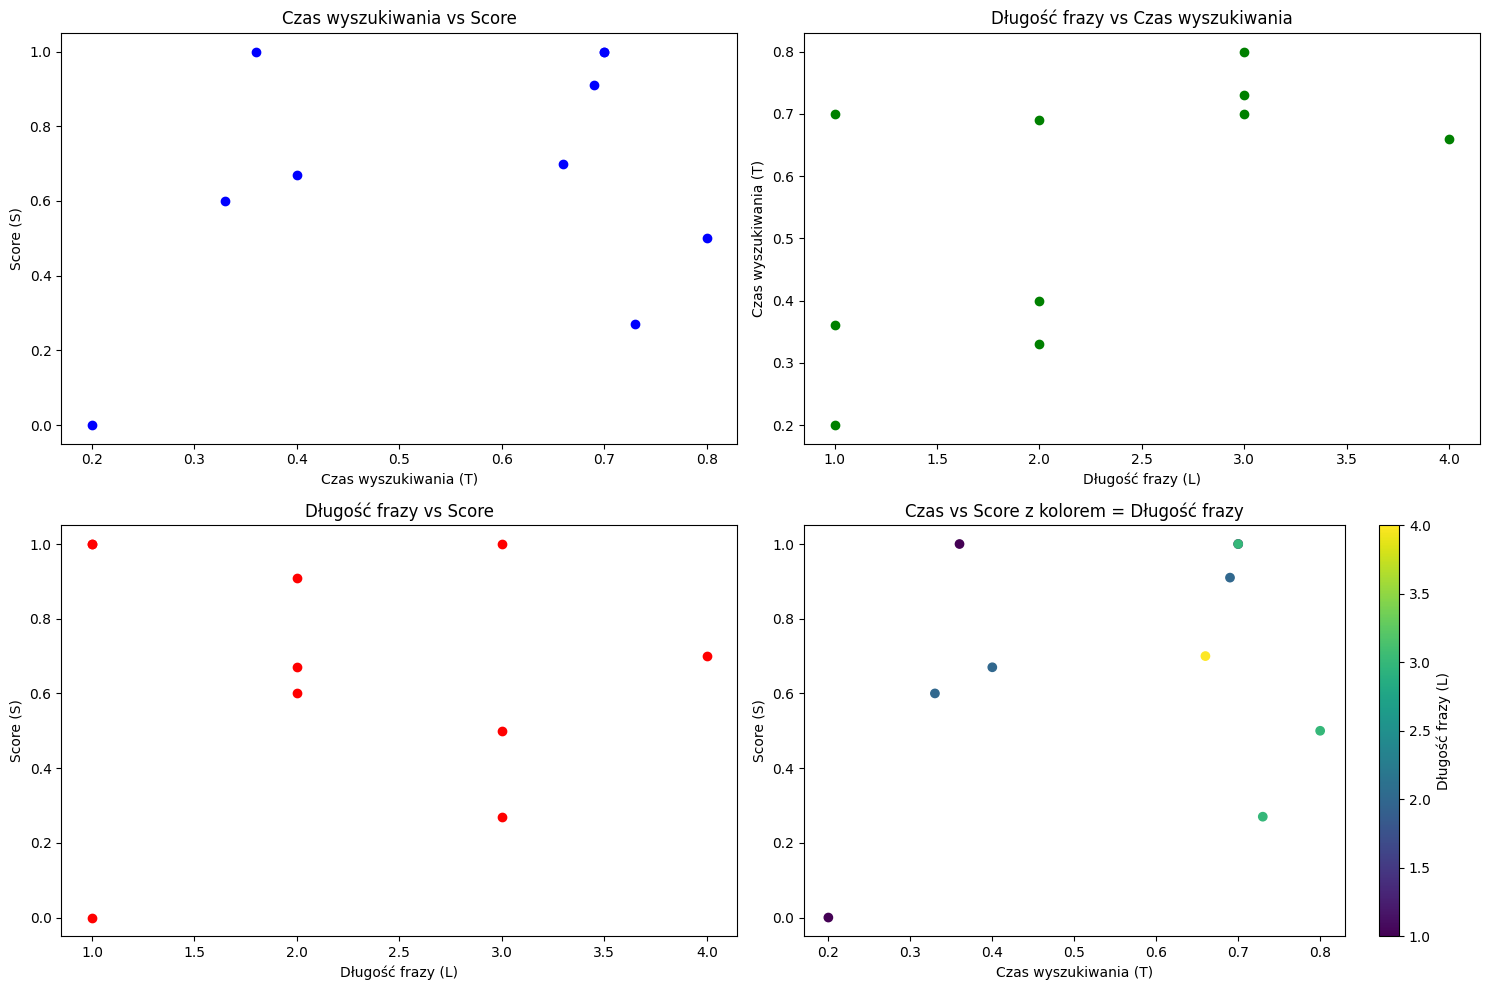

In [ ]:
# Tylko pierwsza część testowa
draw_plot(T,S,L)
# Dla popularniejszych fraz score był odwrotnie proporcjonlany do długości wpisywanej fraz, czas wyszukiwania był różny( zależny o ilość wystąpień w data secie)
# Dla dłuższych fraz czas wyszukiwania był większy, jednak dłuższy czas wyszukiwania nie świadczył jednocznacznie o lepszym scorze

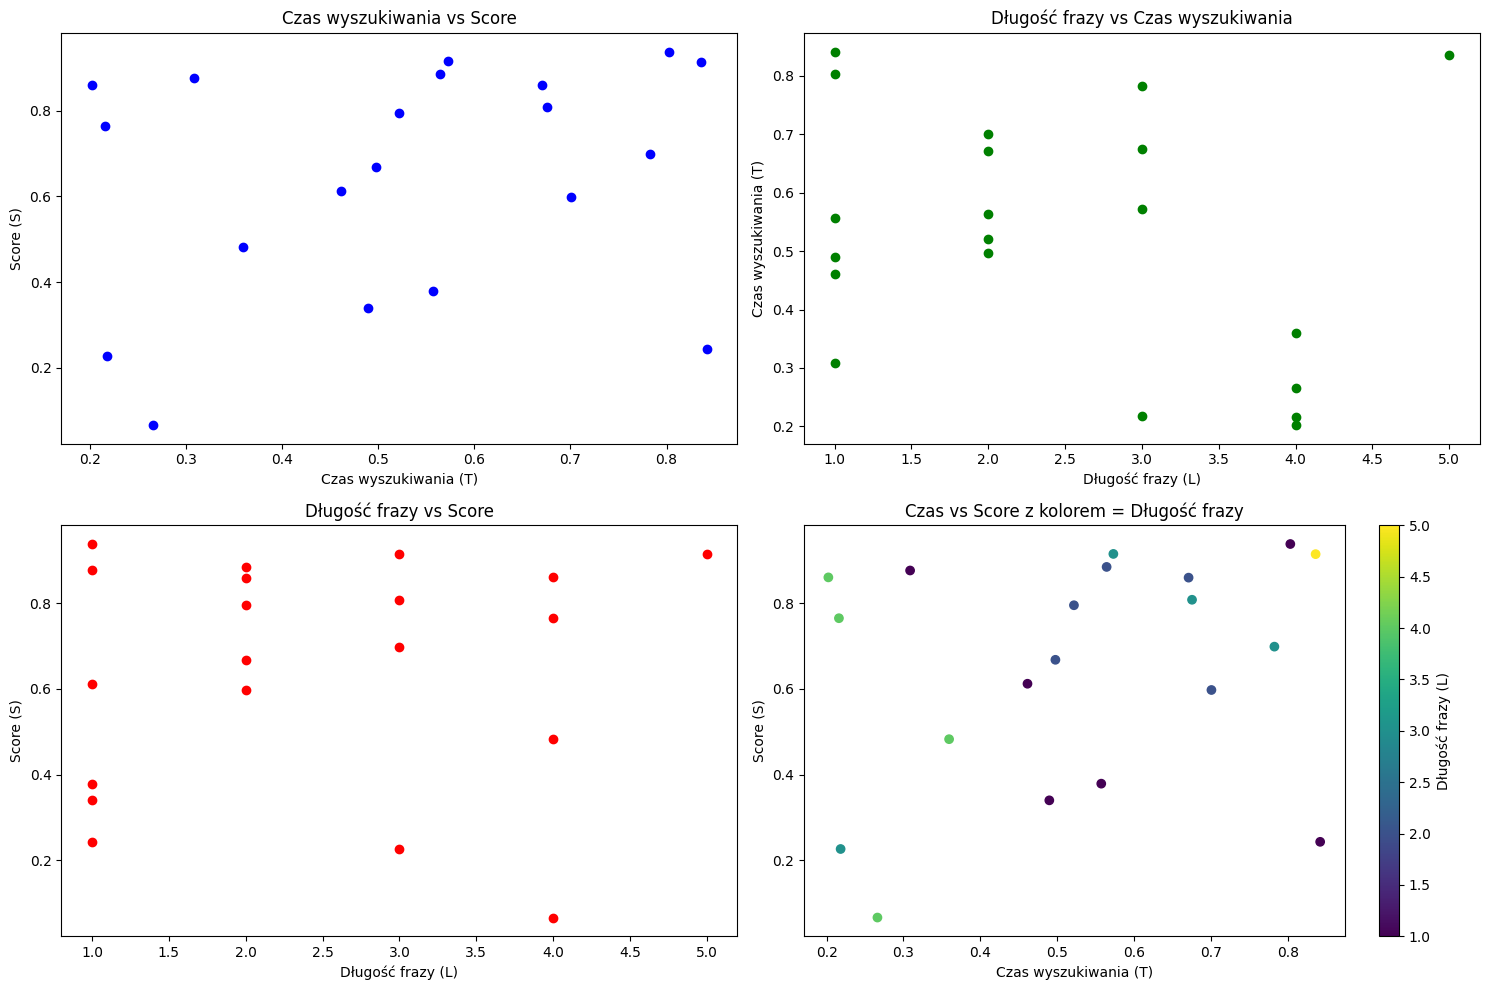

In [ ]:
# Frazy rzadsze
draw_plot(T2,S2,L2)
# Tutaj wszystkie próby już osiągnęły znacznie niższe scory, czas wyszukiwania był zależny od długości frazy

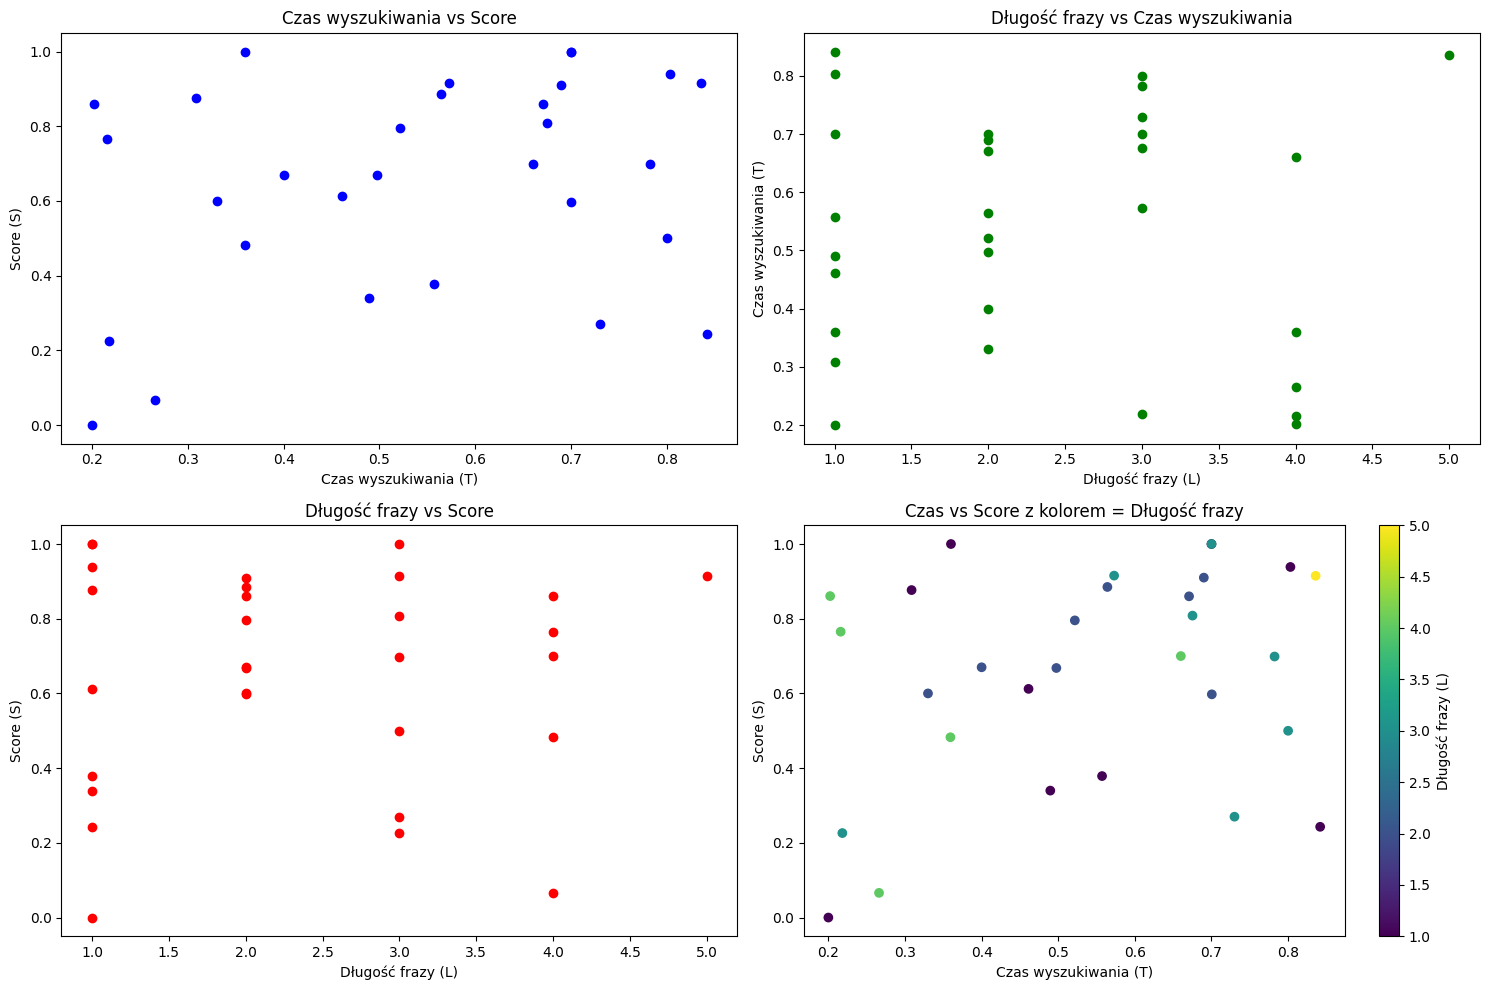

In [ ]:
# Połączone
draw_plot(T+T2,S+S2,L+L2)
# Dłuższy czas wyszukiwania głównie świadczył o lepszym scorze, długość frazy też wpływała na wyniki wyszukiwania

### Porównanie wyszukiwania z użyciem IDF i bez


Aby wykonac wyszukiwanie bez uzycia idf wykomentowano część kodu i ponownie obliczono macierz wynikową

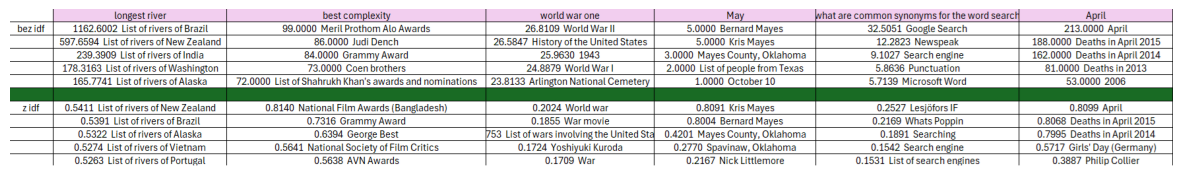

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("data1.png")
plt.figure(figsize=(15, 4))
plt.imshow(img)
plt.axis('off') 
plt.show()

Wszystkie zapytania wykonywały się w podobnym czasie(0.2-0.25s), więc nie będę oddzielnie analizował ich różnicy.

Jak widać im dłuższe wyszukiwanie tym wyniki odbiegają od siebie bardziej

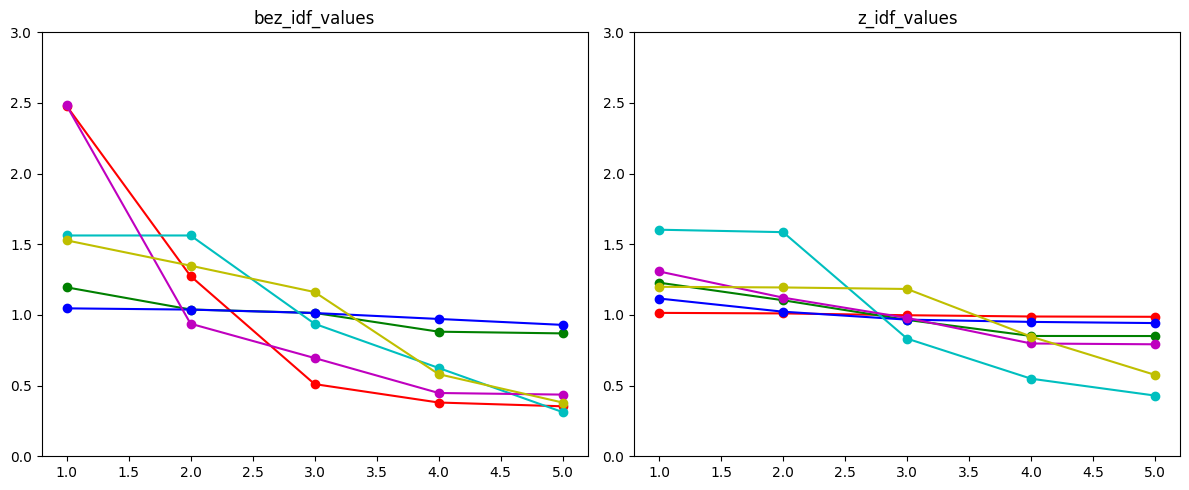

In [ ]:
import matplotlib.pyplot as plt

bez_idf_values = [
    [1162.6002, 597.6594, 239.3909, 178.3163, 165.7741],
    [99.0000, 86.0000, 84.0000, 73.0000, 72.0000],
    [26.8109, 26.5847, 25.9630, 24.8879, 23.8133],
    [5.0000, 5.0000, 3.0000, 2.0000, 1.0000],
    [32.5051, 12.2823, 9.1027, 5.8636, 5.7139],
    [213.0000, 188.0000, 162.0000, 81.0000, 53.0000]
]

z_idf_values = [
    [0.5411, 0.5391, 0.5322, 0.5274, 0.5263],
    [0.8140, 0.7316, 0.6394, 0.5641, 0.5638],
    [0.2024, 0.1855, 0.1753, 0.1724, 0.1709],
    [0.8091, 0.8004, 0.4201, 0.2770, 0.2167],
    [0.2527, 0.2169, 0.1891, 0.1542, 0.1531],
    [0.8099, 0.8068, 0.7995, 0.5717, 0.3887]
]

for i in range(6):
    bez_idf_avg = sum(bez_idf_values[i]) / 5
    z_idf_avg = sum(z_idf_values[i]) / 5
    for j in range(5):
        bez_idf_values[i][j] /= bez_idf_avg
        z_idf_values[i][j] /= z_idf_avg

colors = ['r', 'g', 'b', 'c', 'm', 'y']
x = range(1, 6)  

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i in range(6):
    plt.plot(x, bez_idf_values[i], color=colors[i], marker='o', label=f'Set {i+1}')
plt.title('bez_idf_values')
plt.ylim(0, 3) 

plt.subplot(1, 2, 2)
for i in range(6):
    plt.plot(x, z_idf_values[i], color=colors[i], marker='o', label=f'Set {i+1}')
plt.title('z_idf_values')
plt.ylim(0, 3) 

plt.tight_layout()
plt.show()

# 8. - 9. Podjeście drugie 

W tym podejsciu użyejmy SVD( 8 i 9 punkt konspektu). Niestety w Rust nie ma żadnej impelmentacji bibliotecznej na macierzach rzadkich.( Operajce na macierzach gęstych będą zbyt kosztowe i niemożliwe do przeliczenia). Dodatkowo implementacje macierzy rzadkich w Rust nie mają wielu metod, które by umożliwiały przydatne nam operacje, dlatego będziemy "skakć" między różnymi implementacjami( będzie to wydajniejsze).

Do obliczenia SVD na macierzach rzadkich użyjemy algorytmu Goluba-Kahana-Lanczosa. Głównym minusem działania tego algorytmu jest jego niestabilność numeryczna, dlatego usprawnimy jego działanie poprzez wielokortne wplatanie ortogonalności. https://en.wikipedia.org/wiki/Bidiagonalization

Do porównania efektywności użyjemy tylko tych samych zapytań, którymi posłużyliśmy się w pierwszym podjeściu. Tutaj należy poczynić następującą uwagę: optymalnie dla takiego dużego zbioru danych(pod względem efektywności) byłoby użyć dużego k. Dla k = 350 i iteracji = 1000 algorytm liczył się 3dni, a działanie na tak dużej macierzy wynikowej było bardzo wolne i nieefektywne, więc ograniczono się do k >= 100, żeby wyniki wyszukiwania były jakkolwiek akceptowalne czasowo.

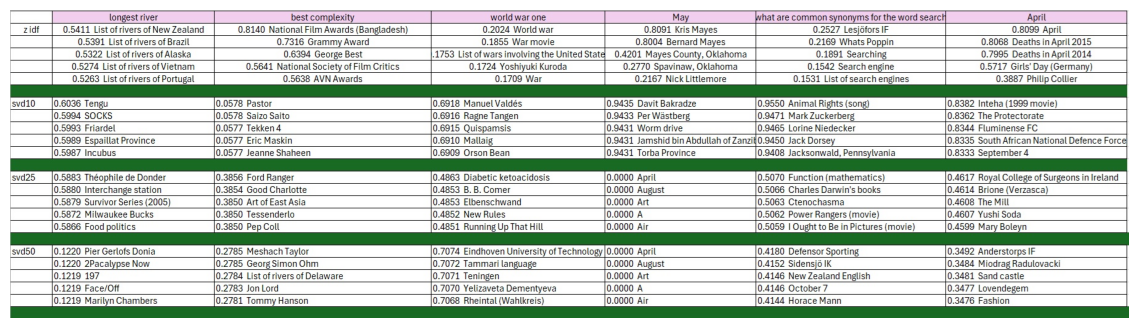

In [3]:
img = mpimg.imread("data2.png")
plt.figure(figsize=(15, 4))
plt.imshow(img)
plt.axis('off') 
plt.show()

Jak widać na załączony screenie, wyniki działania SVD są niepoprawne. Zostało to spowodowane najprawdopodobniej błędami w impelmentacji algorytmów aproksymacji

Obliczenia dla k = 350.
Dla dużo większych wartości k wyszukiwanie zaczyna zwracać oczekiwane wyniki.

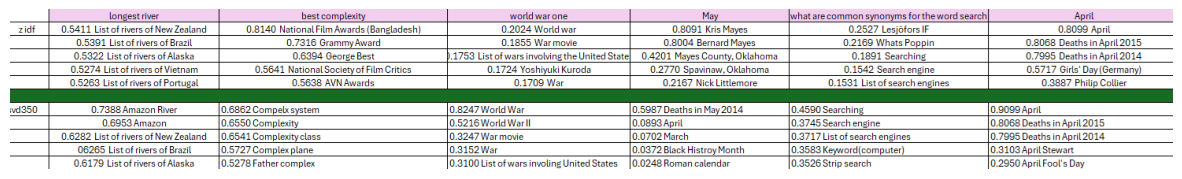

In [3]:
img = mpimg.imread("data3.png")
plt.figure(figsize=(15, 4))
plt.imshow(img)
plt.axis('off') 
plt.show()

# 10. Frontend 
Implementacja w React (Vite), kod i szczegóły w plikach. API z użyciem actix-web
